In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 重抽樣

### 置換檢驗

In [3]:
# 讀取資料集
session_times = pd.read_csv("../../data/web_page_data.csv")

print(session_times.head())

     Page  Time
0  Page A  0.21
1  Page B  2.53
2  Page A  0.35
3  Page B  0.71
4  Page A  0.67


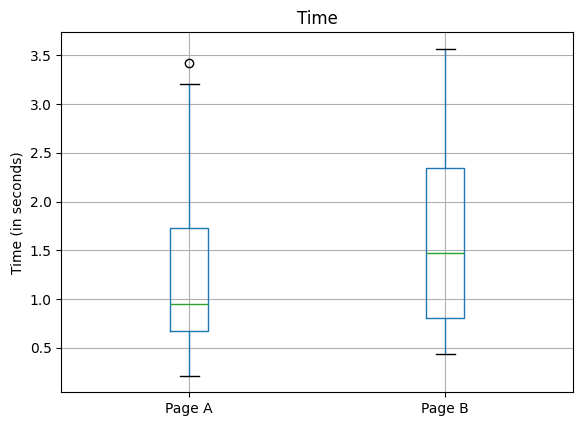

In [ ]:
# 畫boxplot 比對
ax = session_times.boxplot(by='Page', column='Time')
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('');

In [5]:
# 計算出A/B頁面平均的差值
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)

0.3566666666666669


In [2]:
# 定義置換檢驗抽樣函式
import random

def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    idx_A = list(idx_A)
    idx_B = list(idx_B)
    
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()

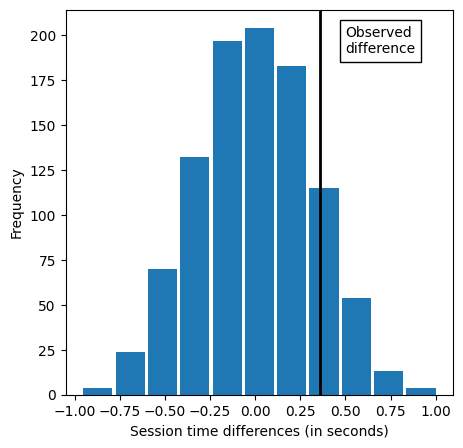

In [22]:
# 執行1000次重抽樣 並生成直方圖
nA = 21
nB = 15
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=mean_b - mean_a, color='black', lw=2)
ax.text(0.5, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency');

In [25]:
# 算出差異值在置換分布中的百分比
print(np.mean(perm_diffs > mean_b - mean_a))

0.136


## 統計顯著性和p值

Ovserved difference: 0.0368%


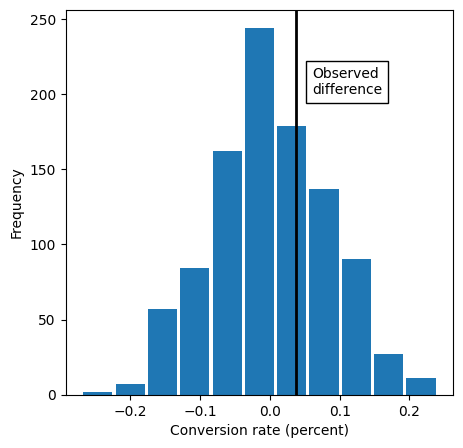

In [4]:
# 建立隨機置換之轉換率差異的直方圖
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Ovserved difference: {obs_pct_diff:.4f}%')
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588)
              for _ in range(1000)]


fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency');

### p 值

In [5]:
# 計算置換檢驗中大於觀測差異值的比例
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.341


In [2]:
from scipy import stats
# 用常態分布近似去估計p 值
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


## t 檢定

In [4]:
# 用t 檢定得到p 值
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time,
                      session_times[session_times.Page == 'Page B'].Time,
                      equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.1408


## ANOVA 變異數分析

In [5]:
# 讀取資料集
four_sessions = pd.read_csv("../../data/four_sessions.csv")

print(four_sessions.head())

     Page  Time
0  Page 1   164
1  Page 2   178
2  Page 3   175
3  Page 4   155
4  Page 1   172


In [19]:
# 置換測驗的方式 算多組比較的p 值
observed_variance = four_sessions.groupby('Page').mean().var().iloc[0]
print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)

def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var().iloc[0]

perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))


Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
Pr(Prob) 0.07433333333333333


### F 統計量

In [22]:
# 使用statsmodels 套件計算ANOVA
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.ols('Time ~ Page', data=four_sessions).fit()

aov_table = sm.stats.anova_lm(model)
print(aov_table)

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


## 卡方檢定

### 重抽樣法

In [26]:
# 讀取資料集
clicks = pd.read_csv("../../data/click_rates.csv")

clicks = clicks.pivot(index='Click', columns='Headline', values='Rate')
print(clicks)


Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


In [27]:
import random
# 重抽樣法
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # 回傳平方和
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [expected_clicks, expected_noclicks]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    random.shuffle(box)
    sample_clicks = [sum(box[0:1000]),
                     sum(box[1000:2000]),
                     sum(box[2000:3000])]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')


Observed chi2: 1.6659
Resampled p-value: 0.4400


### 卡方檢定: 統計理論

In [30]:
from scipy import stats
# 用卡方分布近似去估計p 值
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Ovserved chi2: {chisq:.4f}')
print(f'p-value: {p_value:.4f}')

Ovserved chi2: 1.6659
p-value: 0.6996


## 統計檢定力與樣本規模

### 樣本規模

In [31]:
# 10% 的提升
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 116602.391


In [32]:
# 50% 的提升
effect_size = sm.stats.proportion_effectsize(0.0165, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size, 
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 5488.408
